In [1]:
import os
import numpy as np
import tensorflow as tf
import PIL.Image
import matplotlib as mpl
import IPython.display as display

In [2]:
def download(url, max_dim=None):
    name = os.getcwd() + url.split('/')[-1] + '.jpg'
    image_path = tf.keras.utils.get_file('name', url)
    img = PIL.Image.open(image_path)
    if max_dim:
        img.thumbnail((max_dim, max_dim))
    return np.array(img)

In [3]:
def deprocess(img):
    img = 255 * (img + 1.0) / 2.0
    return tf.cast(img, tf.uint8)

In [4]:
def show(img):
    return display.display(PIL.Image.fromarray(np.array(img)))

In [5]:
url = 'https://image.businessinsider.com/5d9b9acc49e03f38f4481121?width=1100&format=jpeg&auto=webp'

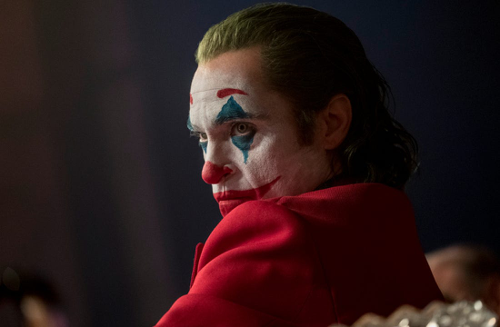

In [6]:
og_img = download(url, max_dim=500)
show(og_img)

In [7]:
base_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')

In [8]:
names = ['mixed3', 'mixed5']
layers = [base_model.get_layer(name).output for name in names]

dream_model = tf.keras.Model(inputs=base_model.input, outputs=layers)

In [9]:
def calc_loss(img, model):

    # Converts the image into a batch of size 1.
    img_batch = tf.expand_dims(img, axis=0)
    
    layer_activations = model(img_batch)

    losses = []
    for act in layer_activations:
        loss = tf.math.reduce_mean(act)
        losses.append(loss)

    return  tf.reduce_sum(losses)

### Gradient Ascent

<strong> In gradient ascent, the "loss" is maximized so that the input image increasingly "excites" the layers.

In [10]:
class Dream(tf.Module):
    def __init__(self, model):
        self.model = model

    @tf.function(
      input_signature=(
        tf.TensorSpec(shape=[None,None,3], dtype=tf.float32),
        tf.TensorSpec(shape=[], dtype=tf.int32),
        tf.TensorSpec(shape=[], dtype=tf.float32),)
    )
    def __call__(self, img, steps, step_size):
        print("Dreaming..")
        loss = tf.constant(0.0)
        for n in tf.range(steps):
            with tf.GradientTape() as tape:
                tape.watch(img)
                loss = calc_loss(img, self.model)

            gradients = tape.gradient(loss, img)
            gradients /= tf.math.reduce_std(gradients) + 1e-8 
        
            img = img + gradients*step_size
            img = tf.clip_by_value(img, -1, 1)
        return loss, img

In [11]:
dream = Dream(dream_model)

In [12]:
def deep_dream(img, steps=100, step_size=0.01):
    
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    img = tf.convert_to_tensor(img)
    step_size = tf.convert_to_tensor(step_size)
    steps_remaining = steps
    step = 0
    while steps_remaining:
        print('Steps remaining: ', steps_remaining)
        if steps_remaining>100:
            run_steps = tf.constant(100)
        else:
            run_steps = tf.constant(steps_remaining)
        steps_remaining -= run_steps
        step += run_steps

        loss, img = dream(img, run_steps, tf.constant(step_size))

        display.clear_output(wait=True)
        show(deprocess(img))
        print ("Step {}, loss {}".format(step, loss))


        result = deprocess(img)
        display.clear_output(wait=True)
        show(result)

    return result


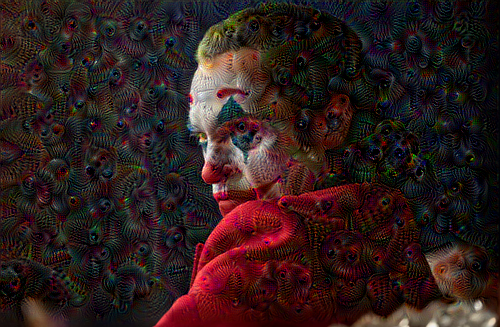

In [13]:
dream_img = deep_dream(img=og_img)

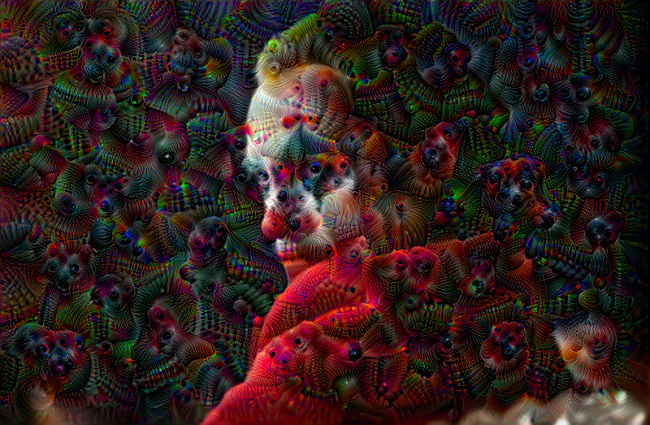

Steps remaining:  50


In [ ]:
import time
start = time.time()

OCTAVE_SCALE = 1.30

img = tf.constant(np.array(og_img))
base_shape = tf.shape(img)[:-1]
float_base_shape = tf.cast(base_shape, tf.float32)

for n in range(-2, 3):
    new_shape = tf.cast(float_base_shape*(OCTAVE_SCALE**n), tf.int32)

    img = tf.image.resize(img, new_shape).numpy()

    img = deep_dream(img=img, steps=50, step_size=0.01)

display.clear_output(wait=True)
img = tf.image.resize(img, base_shape)
img = tf.image.convert_image_dtype(img/255.0, dtype=tf.uint8)
show(img)

end = time.time()
end-start